In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
from pathlib import Path
import random



In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("PyTorch version:", torch.__version__)
print("Device:", device)

PyTorch version: 2.5.1+cu121
Device: cpu


/home/manmath/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
from pathlib import Path
corpus_path = Path("data/corpus.txt")

corpus_path.parent.mkdir(parents=True, exist_ok=True)
if not corpus_path.exists():
    with open(corpus_path, "w") as f:
        f.write(
            "I love natural language processing\n"
            "I love deep learning\n"
            "Language models unnderstand context\n"
            "Deep learning powers transformers\n"
        )
with open(corpus_path, "r") as f:
    corpus = [line.strip().lower().split() for line in f if line.strip()]

vocab = sorted(set(word for sent in corpus for word in sent))
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}

print("Loaded from: ", corpus_path)
print("Number of senteneces: ", len(corpus))
print("Vocabulary: ", vocab)
print("Vocab size: ", len(vocab))

Loaded from:  data/corpus.txt
Number of senteneces:  20
Vocabulary:  ['artificial', 'barked', 'boy', 'capture', 'castle', 'cat', 'chased', 'chess', 'climbed', 'daughter', 'deep', 'dog', 'embeddings', 'enables', 'football', 'for', 'future', 'girl', 'hard', 'have', 'her', 'his', 'intelligence', 'is', 'king', 'kingdom', 'language', 'learning', 'loudly', 'loves', 'machine', 'man', 'mat', 'meaning', 'modern', 'natural', 'nlp', 'of', 'on', 'plays', 'powers', 'prince', 'princess', 'processing', 'queen', 'rules', 'sat', 'similar', 'smart', 'son', 'stands', 'student', 'students', 'studies', 'systems', 'teacher', 'teaches', 'the', 'tree', 'vectors', 'woman', 'word', 'words']
Vocab size:  63


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

WINDOW_SIZE = 2
BATCH_SIZE = 8

pairs = []
for sent in corpus:
    ids = [word_to_ix[w] for w in sent]
    for i, center_id in enumerate(ids):
        for j in range(max(0, i-WINDOW_SIZE), min(len(ids), i+WINDOW_SIZE+1)):
            if j == i:
                continue
            context_id = ids[j]
            pairs.append((center_id, context_id))
print("Total Pairs Created: ", len(pairs))
print("Example pairs (word center -> context):")
for c, k in pairs[:10]:
    print(f" {ix_to_word[c]} -> {ix_to_word[k]}")

centers = torch.tensor([c for c, _ in pairs], dtype=torch.long, device=device)
contexts = torch.tensor([k for k, _ in pairs], dtype=torch.long, device=device)

class SkipGramDataset(Dataset):
    def __init__(self, centers, contexts):
        self.centers = centers
        self.contexts = contexts
    def __len__(self):
        return self.centers.size(0)
    def __getitem__(self, idx):
        return self.centers[idx], self.contexts[idx]

dataset = SkipGramDataset(centers, contexts)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for bc, bk in dataloader:
    print("\nOne Batch (center_ids):", bc)
    print("One Batch (context_ids): ", bk)
    break

Total Pairs Created:  288
Example pairs (word center -> context):
 the -> cat
 the -> sat
 cat -> the
 cat -> sat
 cat -> on
 sat -> the
 sat -> cat
 sat -> on
 sat -> the
 on -> cat

One Batch (center_ids): tensor([29, 35, 57, 45,  8, 57, 37, 57])
One Batch (context_ids):  tensor([29, 35, 57, 45,  8, 57, 37, 57])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramModel, self).__init__()

        self.center_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embed_dim)

        nn.init.uniform_(self.center_embeddings.weight, -0.5/embed_dim, 0.5/embed_dim)
        nn.init.uniform_(self.context_embeddings.weight, -0.5/embed_dim, 0.5/embed_dim)

    def forward(self, center_ids, context_ids):
        center_vecs = self.center_embeddings(center_ids)
        context_vecs = self.context_embeddings(context_ids)

        dot_products = torch.sum(center_vecs * context_vecs, dim=1)

        log_probs = F.logsigmoid(dot_products)

        return -log_probs.mean()

In [8]:
import torch.optim as optim
import time
import math
from collections import defaultdict

EPOCHS = 50
LR = 0.01
EMBED_DIM=50
VOCAB_SIZE=len(vocab)
CLIP_GRAD_NORM=5.0

model = SkipGramModel(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

epoch_losses = []
start_time = time.time()

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    batch_count = 0

    for center_ids, context_ids in dataloader:
        center_ids = center_ids.to(device)
        context_ids = context_ids.to(device)

        optimizer.zero_grad()
        loss = model(center_ids, context_ids)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)

        optimizer.step()

        total_loss += loss.item()
        batch_count += 1
    
    avg_loss = total_loss / max(1, batch_count)
    epoch_losses.append(avg_loss)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch:02d}/{epoch:02d} avg_loss: {avg_loss:.4f} elapsed: {math.floor(elapsed)}s")

print("\nTraining Finished - saving embeddings to disk")

out_dir = Path("models")
out_dir.mkdir(exist_ok=True, parents=True)
center_weights = model.center_embeddings.weight.detach().cpu().numpy()
context_weights = model.context_embeddings.weight.detach().cpu().numpy()

np.save(out_dir / "center_embeddings.npy", center_weights)
np.save(out_dir / "context_embeddings.npy", context_weights)

print(f"Saved center_embeddings.npy and context_embeddings.npy in {out_dir}/")

Epoch 01/01 avg_loss: 0.5820 elapsed: 0s
Epoch 02/02 avg_loss: 0.2608 elapsed: 0s
Epoch 03/03 avg_loss: 0.0711 elapsed: 0s
Epoch 04/04 avg_loss: 0.0181 elapsed: 0s
Epoch 05/05 avg_loss: 0.0076 elapsed: 0s
Epoch 06/06 avg_loss: 0.0045 elapsed: 0s
Epoch 07/07 avg_loss: 0.0030 elapsed: 0s
Epoch 08/08 avg_loss: 0.0022 elapsed: 0s
Epoch 09/09 avg_loss: 0.0016 elapsed: 0s
Epoch 10/10 avg_loss: 0.0013 elapsed: 0s
Epoch 11/11 avg_loss: 0.0010 elapsed: 0s
Epoch 12/12 avg_loss: 0.0009 elapsed: 0s
Epoch 13/13 avg_loss: 0.0007 elapsed: 0s
Epoch 14/14 avg_loss: 0.0006 elapsed: 0s
Epoch 15/15 avg_loss: 0.0005 elapsed: 0s
Epoch 16/16 avg_loss: 0.0005 elapsed: 0s
Epoch 17/17 avg_loss: 0.0004 elapsed: 0s
Epoch 18/18 avg_loss: 0.0004 elapsed: 0s
Epoch 19/19 avg_loss: 0.0003 elapsed: 0s
Epoch 20/20 avg_loss: 0.0003 elapsed: 0s
Epoch 21/21 avg_loss: 0.0003 elapsed: 0s
Epoch 22/22 avg_loss: 0.0002 elapsed: 0s
Epoch 23/23 avg_loss: 0.0002 elapsed: 0s
Epoch 24/24 avg_loss: 0.0002 elapsed: 0s
Epoch 25/25 avg_

In [9]:
import numpy as np

center_emb = np.load("models/center_embeddings.npy")
context_emb = np.load("models/context_embeddings.npy")

embeddings = (center_emb + context_emb) / 2.0

def normalize_rows(x):
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    return x / norms
emb_norm = normalize_rows(embeddings)

def most_similar(word, topn=10):
    if word not in word_to_ix:
        raise KeyError(f"Word '{word}' not in vocab")
    qid = word_to_ix[word]
    qvec = emb_norm[qid]
    sims = emb_norm.dot(qvec)

    best = np.argsort(-sims)
    neighbors = []
    for idx in best:
        if idx == qid:
            continue
        neighbors.append((ix_to_word[idx], float(sims[idx])))
        if len(neighbors) >= topn:
            break
    return neighbors

demo_words = ["nlp", "learning", "coding", "tokenizers", "enjoy"]
for w in demo_words:
    try:
        print(f"\nNearest to '{w}':")
        for neighbors, score in most_similar(w, topn=6):
            print(f"   {neighbors:15s}  {score:.4f}")
    except KeyError as e:
        print(e)


Nearest to 'nlp':
   man              0.3921
   machine          0.2442
   intelligence     0.1846
   modern           0.1763
   for              0.1609
   language         0.1522

Nearest to 'learning':
   meaning          0.4556
   students         0.3525
   teacher          0.2397
   cat              0.2354
   smart            0.2165
   student          0.1994

Nearest to 'coding':
"Word 'coding' not in vocab"

Nearest to 'tokenizers':
"Word 'tokenizers' not in vocab"

Nearest to 'enjoy':
"Word 'enjoy' not in vocab"


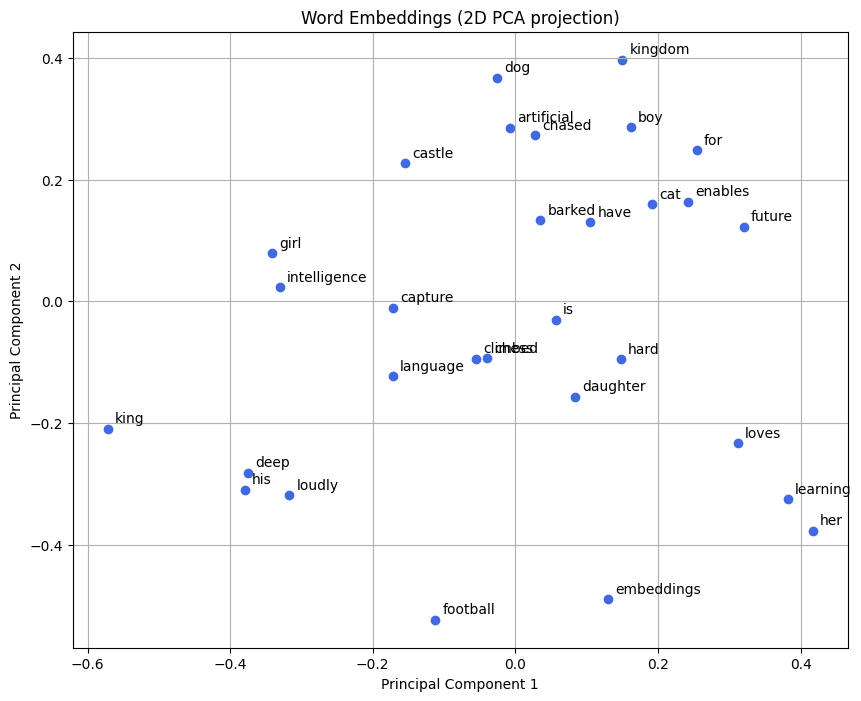

In [11]:
# Cell 7 — Visualize learned embeddings (PCA 2D projection)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 1️⃣ Load embeddings (same as before)
center_emb = np.load("models/center_embeddings.npy")
context_emb = np.load("models/context_embeddings.npy")
embeddings = (center_emb + context_emb) / 2.0

# 2️⃣ Normalize embeddings (for clean cosine-like geometry)
def normalize_rows(x):
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    return x / norms

emb_norm = normalize_rows(embeddings)

# 3️⃣ PCA: reduce high-dimensional vectors (e.g., 50D) to 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_norm)

# 4️⃣ Plot subset of vocabulary for clarity
plt.figure(figsize=(10, 8))
subset_size = min(30, len(vocab))  # show first 30 words max
words_to_plot = vocab[:subset_size]

for word in words_to_plot:
    idx = word_to_ix[word]
    x, y = emb_2d[idx]
    plt.scatter(x, y, color="royalblue")
    plt.text(x + 0.01, y + 0.01, word, fontsize=10)

plt.title("Word Embeddings (2D PCA projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
